In [1]:
!wget https://github.com/imguru-mooc/AI_VISION/raw/main/4_day/1.YOLOv1/1.YOLOv1.zip

--2023-10-18 23:09:30--  https://github.com/imguru-mooc/AI_VISION/raw/main/4_day/1.YOLOv1/1.YOLOv1.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/imguru-mooc/AI_VISION/main/4_day/1.YOLOv1/1.YOLOv1.zip [following]
--2023-10-18 23:09:30--  https://raw.githubusercontent.com/imguru-mooc/AI_VISION/main/4_day/1.YOLOv1/1.YOLOv1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11283 (11K) [application/zip]
Saving to: ‘1.YOLOv1.zip’

1.YOLOv1.zip        100%[===================>]  11.02K  --.-KB/s    in 0s      

2023-10-18 23:09:30 (108 MB/s) - ‘1.YOLOv1.zip’ saved [11283/11283]



In [2]:
!unzip 1.YOLOv1.zip

Archive:  1.YOLOv1.zip
   creating: data/
  inflating: data/generate_csv.py    
  inflating: data/get_data.sh        
  inflating: data/voc_label.py       
  inflating: dataset.py              
  inflating: loss.py                 
  inflating: model.py                
  inflating: train.py                
  inflating: utils.py                


In [3]:
!bash data/get_data.sh

--2023-10-18 23:09:49--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  23.3MB/s    in 21s     

2023-10-18 23:10:11 (20.5 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2023-10-18 23:10:11--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

In [4]:
"""
Main file for training Yolo model on Pascal VOC dataset
"""

import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import Yolov1
from dataset import VOCDataset
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from loss import YoloLoss

seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 32 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 50
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():

    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "data/train.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "data/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )



    for epoch in range(EPOCHS):
        # for x, y in train_loader:
        #    x = x.to(DEVICE)
        #    for idx in range(8):
        #        bboxes = cellboxes_to_boxes(model(x))
        #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        #    import sys
        #    sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Epoch: {epoch} , Train mAP: {mean_avg_prec}")

        #if mean_avg_prec > 0.9:
        #    checkpoint = {
        #        "state_dict": model.state_dict(),
        #        "optimizer": optimizer.state_dict(),
        #    }
        #    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
        #    import time
        #    time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)

In [5]:
if __name__ == "__main__":
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    main()

Epoch: 0 , Train mAP: 0.0


100%|██████████| 78/78 [00:49<00:00,  1.56it/s, loss=490]

Mean loss was 973.9265962258363


Epoch: 1 , Train mAP: 0.00010553411993896589


100%|██████████| 78/78 [00:50<00:00,  1.54it/s, loss=478]

Mean loss was 470.8829365265675


Epoch: 2 , Train mAP: 0.00262062787078321


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=371]

Mean loss was 363.372069138747


Epoch: 3 , Train mAP: 0.007441730238497257


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=305]

Mean loss was 323.7982715704502


Epoch: 4 , Train mAP: 0.010242710821330547


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=293]

Mean loss was 295.9872718224159


Epoch: 5 , Train mAP: 0.034230686724185944


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=371]

Mean loss was 272.5730287600786


Epoch: 6 , Train mAP: 0.06903346627950668


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=217]

Mean loss was 251.9839387551332


Epoch: 7 , Train mAP: 0.05541408807039261


100%|██████████| 78/78 [00:51<00:00,  1.50it/s, loss=274]

Mean loss was 232.3829152033879


Epoch: 8 , Train mAP: 0.04268305003643036


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=225]

Mean loss was 217.4088334303636


Epoch: 9 , Train mAP: 0.19843290746212006


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=207]

Mean loss was 201.3774924645057


Epoch: 10 , Train mAP: 0.2908626198768616


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=202]

Mean loss was 189.87555635892429


Epoch: 11 , Train mAP: 0.3013065457344055


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=123]

Mean loss was 176.04068893041367


Epoch: 12 , Train mAP: 0.2798077166080475


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=172]

Mean loss was 164.5153437883426


Epoch: 13 , Train mAP: 0.4906953275203705


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=140]

Mean loss was 153.50971407768054


Epoch: 14 , Train mAP: 0.5353947281837463


100%|██████████| 78/78 [00:51<00:00,  1.50it/s, loss=109]

Mean loss was 148.63150611290564


Epoch: 15 , Train mAP: 0.5563389658927917


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=127]

Mean loss was 142.16375849797174


Epoch: 16 , Train mAP: 0.5628154873847961


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=143]

Mean loss was 137.99550853631436


Epoch: 17 , Train mAP: 0.6257238984107971


100%|██████████| 78/78 [00:51<00:00,  1.50it/s, loss=144]

Mean loss was 133.69502962552585


Epoch: 18 , Train mAP: 0.6486449837684631


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=135]

Mean loss was 127.58636367015349


Epoch: 19 , Train mAP: 0.6952358484268188


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=159]

Mean loss was 123.77004506037785


Epoch: 20 , Train mAP: 0.6922098398208618


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=110]

Mean loss was 118.4815800006573


Epoch: 21 , Train mAP: 0.5610302686691284


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=103]

Mean loss was 114.72076758360251


Epoch: 22 , Train mAP: 0.729777991771698


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=87.5]

Mean loss was 111.9171891823793


Epoch: 23 , Train mAP: 0.7490012049674988


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=118]

Mean loss was 106.71740204248673


Epoch: 24 , Train mAP: 0.7047768831253052


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=78.4]

Mean loss was 105.3035746843387


Epoch: 25 , Train mAP: 0.7757887840270996


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=69.3]

Mean loss was 101.47707327818259


Epoch: 26 , Train mAP: 0.776648759841919


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=101]

Mean loss was 96.52075968033228


Epoch: 27 , Train mAP: 0.7235246300697327


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=145]

Mean loss was 95.93238224127354


Epoch: 28 , Train mAP: 0.7473456263542175


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=77]

Mean loss was 97.4793573037172


Epoch: 29 , Train mAP: 0.7936790585517883


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=108]

Mean loss was 91.28570038233048


Epoch: 30 , Train mAP: 0.7664937973022461


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=96.4]

Mean loss was 89.51901846665602


Epoch: 31 , Train mAP: 0.7904349565505981


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=97.3]

Mean loss was 85.90003375518016


Epoch: 32 , Train mAP: 0.8214668035507202


100%|██████████| 78/78 [00:51<00:00,  1.50it/s, loss=83.4]

Mean loss was 83.06662769806691


Epoch: 33 , Train mAP: 0.8127793073654175


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=76.2]

Mean loss was 80.71870813614282


Epoch: 34 , Train mAP: 0.8146072626113892


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=56.8]

Mean loss was 81.08629754873422


Epoch: 35 , Train mAP: 0.8040210008621216


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=97.3]

Mean loss was 79.07266856462527


Epoch: 36 , Train mAP: 0.8257676959037781


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=98.5]

Mean loss was 77.68522443526831


Epoch: 37 , Train mAP: 0.8077185750007629


100%|██████████| 78/78 [00:52<00:00,  1.50it/s, loss=64.1]

Mean loss was 76.60815776922765


Epoch: 38 , Train mAP: 0.7998093962669373


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=61.1]

Mean loss was 74.11539733104216


Epoch: 39 , Train mAP: 0.8194199800491333


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=59.3]

Mean loss was 77.310301951873


Epoch: 40 , Train mAP: 0.8114886283874512


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=80.5]

Mean loss was 71.29617177523099


Epoch: 41 , Train mAP: 0.8271986842155457


100%|██████████| 78/78 [00:51<00:00,  1.52it/s, loss=78.7]

Mean loss was 70.32467489976149


Epoch: 42 , Train mAP: 0.818141758441925


100%|██████████| 78/78 [00:51<00:00,  1.50it/s, loss=102]

Mean loss was 66.71713711665227


Epoch: 43 , Train mAP: 0.8364893794059753


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=41.9]

Mean loss was 66.05980574779021


Epoch: 44 , Train mAP: 0.8325040936470032


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=65.6]

Mean loss was 64.77086727435773


Epoch: 45 , Train mAP: 0.8052395582199097


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=60.6]

Mean loss was 68.43504881247496


Epoch: 46 , Train mAP: 0.8095799684524536


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=67.9]

Mean loss was 63.40086242480156


Epoch: 47 , Train mAP: 0.8197662234306335


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=49.3]

Mean loss was 65.7672063876421


Epoch: 48 , Train mAP: 0.8049854040145874


100%|██████████| 78/78 [00:51<00:00,  1.50it/s, loss=54]

Mean loss was 60.78953346839318


Epoch: 49 , Train mAP: 0.8527237772941589


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=65]

Mean loss was 60.811611860226364


In [6]:
torch.save(model.state_dict(), "yolov1.pt")

In [7]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
model.load_state_dict(torch.load("yolov1.pt"))

<All keys matched successfully>

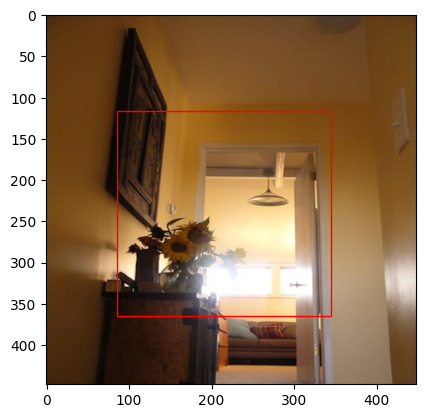

[[12.0, 0.5905327200889587, 0.4793495237827301, 0.5362676978111267, 0.5797343254089355, 0.5551696419715881]]


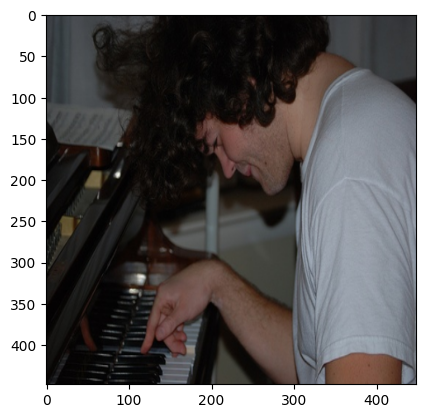

[]


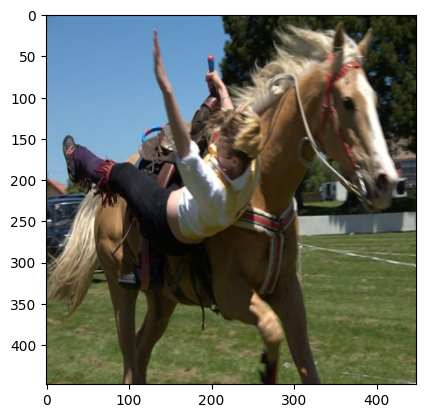

[]


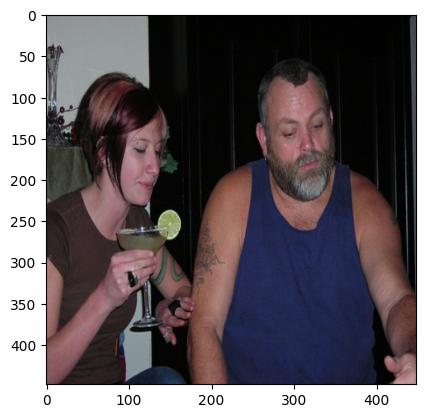

[]


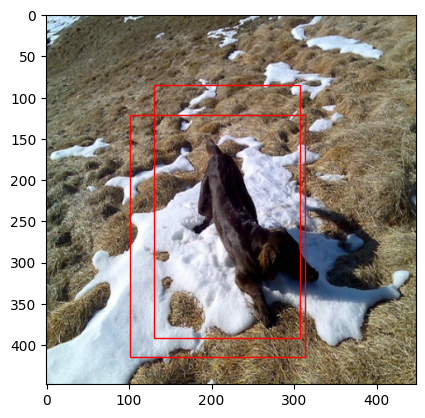

[[14.0, 0.5757033228874207, 0.4886721074581146, 0.5312070250511169, 0.3954154849052429, 0.6855762004852295], [13.0, 0.4668380320072174, 0.46313589811325073, 0.5988795161247253, 0.47227197885513306, 0.6550223231315613]]


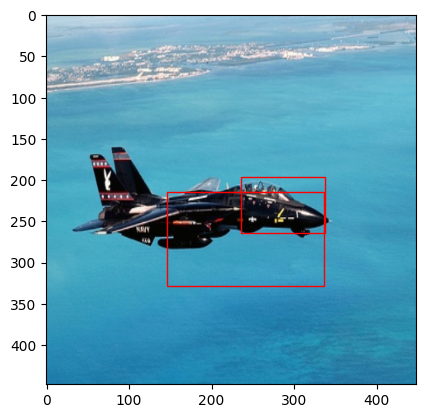

[[0.0, 0.4642835259437561, 0.6393073201179504, 0.513930082321167, 0.2258317768573761, 0.14955513179302216], [0.0, 0.4426101744174957, 0.5384989976882935, 0.6064025163650513, 0.42657893896102905, 0.2553256154060364]]


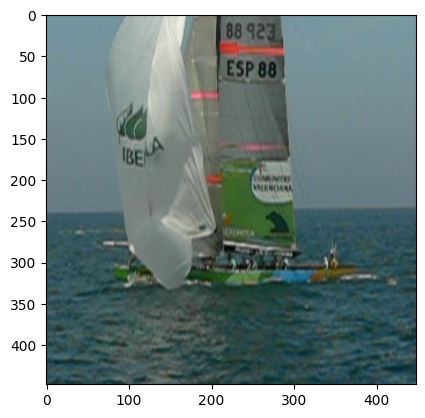

[]


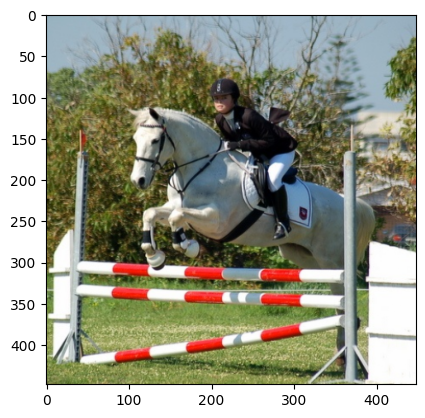

[]


In [8]:
test_dataset = VOCDataset(
    "data/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=8,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

model.eval()

(x, labels) = next(iter(test_loader))
x = x.to(DEVICE)
labels = labels.to(DEVICE)

with torch.no_grad():
    predictions = model(x)

batch_size = x.shape[0]
true_bboxes = cellboxes_to_boxes(labels)
bboxes = cellboxes_to_boxes(predictions)

all_pred_boxes = []
all_true_boxes = []
train_idx = 0

iou_threshold=0.5
threshold=0.4
box_format="midpoint"

for idx in range(batch_size):
    nms_boxes = non_max_suppression(
        bboxes[idx],
        iou_threshold=iou_threshold,
        threshold=threshold,
        box_format=box_format,
    )

    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
    print(nms_boxes)